In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import os
from collections import Counter
from scipy import sparse
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
from itertools import groupby
from typing import Iterable, Any
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('error')

In [4]:
import cProfile
%load_ext line_profiler

In [5]:
class bidict(dict):
    def __init__(self, *args, **kwargs):
        
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value, []).append(key) 

    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value, []).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key], []).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

In [6]:
def normalize(matrix: sparse.spmatrix) -> sparse.spmatrix:
    
    return matrix.T.multiply(1 / matrix.sum(axis=1)).T

In [7]:
def steady_state(transition: sparse.spmatrix, damping: float = .85, tol: float = 1e-12) -> np.ndarray:

    N = transition.shape[0]
    antidamp = (1 - damping) / N
    damped = normalize(transition) * damping
    projection = np.ones(N, dtype=np.int8)
    
    previous_stationary = (projection / N) @ damped# + antidamp
    stationary = previous_stationary @ damped# + antidamp

    while np.linalg.norm(stationary - previous_stationary) > tol:
        previous_stationary = stationary
        stationary = stationary @ damped + antidamp

    return stationary, damped + antidamp * sparse.csr_array((np.ones(damped.count_nonzero()), damped.indices, damped.indptr))

In [8]:
def joint_distribution(states, adjacency):

    return adjacency.T.multiply(states).T.tocsr()

In [9]:
def _cluster_edges(nodes, edges):
        
        return [(neighbor, sum([weight[1] for weight in weights])) 
                for neighbor, weights in groupby(
                    sorted([(nodes[edge], weight) 
                            for _, edge, weight in edges], 
                           key=lambda x: x[0]), 
                    key=lambda x: x[0])]

In [10]:
def objective_part(joint: float, state: float) -> float:

    try:
        x = joint * np.log(joint / state ** 2)
    except Warning:
        x = 0.
    
    try:    
        y = (state - joint) * np.log((state - joint) / state / (1 - state))
    except Warning:
        y = 0.
    
    return x + y

In [11]:
def objective_change(link, node_joint, node_state, cluster_prop):
    
    joint = cluster_prop['joint']
    state = cluster_prop['state']
    current_objective = cluster_prop['objective']
    
    return objective_part(joint + link + node_joint, state + node_state) - current_objective

In [12]:
def objective(graph) -> float:

    membership = bidict(graph.nodes.data('cluster'))
    result = 0.
    for _, nodes in membership.inverse.items():
        sub = graph.subgraph(nodes)
        states = dict(sub.nodes(data='state'))
        state = sum(states.values())
        joint = sum([states[node] * sum([weight 
                                         for _, neighbor, weight in sub.edges(node, data='weight')])
                    for node in nodes])
        if joint > 0:
            result += joint * np.log(joint / state ** 2)
        if joint < state:
            result += (state - joint) * np.log((state - joint) / state / (1 - state))
    
    return result

In [13]:
def merge_graph(original_graph, clusters):
    
    graph = nx.Graph()
    graph.add_nodes_from([(cluster, {'cluster': cluster, 
                                     'state': prop['state'],
                                     'original_nodes': [node 
                                                        for _, nodes in 
                                                        original_graph.subgraph(prop['nodes']).nodes.data('original_nodes') 
                                                        for node in nodes]}) 
                          for cluster, prop in clusters.items()])
    
    graph.add_weighted_edges_from([(cluster, *link) for cluster, prop in clusters.items() 
                                   for link in _cluster_edges(original_graph.nodes.data('cluster'), 
                                                              original_graph.edges(prop['nodes'], data='weight'))])
    
    
    return graph

In [14]:
def louvain(network, tol=1e-6):
    
    graph = network.copy()
    gain = 2 * tol
    
    while gain > tol:
        
        print(graph)
        gain = 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
        change = True
        current_clusters = {cluster: {'state': prop['state'],
                                      'joint': graph.edges.get((cluster, cluster), dict()).get('weight', 0),
                                      'nodes': [cluster]}
                            for cluster, prop in graph.nodes(data=True)}
        [cluster.update({'objective': objective_part(cluster['joint'], cluster['state'])}) 
         for cluster in current_clusters.values()]
        while change:
            
            change = False
            for node, prop in list(graph.nodes(data=True)):
                
                source = prop['cluster']
                source_cluster = current_clusters[source]
                node_state = prop['state']
                node_joint = graph.edges.get((node, node), dict()).get('weight', 0)
                cluster_links = dict(_cluster_edges(graph.nodes.data('cluster'), graph.edges(node, data='weight')))
                internal_links = cluster_links.pop(source, 0)
                
                if cluster_links:
                                        
                    addons = {cluster: 
                              objective_change(link, 
                                               node_joint, node_state,
                                               current_clusters[cluster])
                              for cluster, link in cluster_links.items()}
                    destination = max(addons, key=addons.get)
                    expense = objective_change(-internal_links, 0, -node_state, source_cluster)
                    single_gain = addons[destination] + expense
                    if single_gain > 0:
                        
                        gain += single_gain
                        change = True
                        target_cluster = current_clusters[destination]
                        
                        nx.set_node_attributes(graph, {node: {'cluster': destination}})
                        
                        source_nodes = source_cluster['nodes']
                        target_cluster['nodes'].append(source_nodes.pop(source_nodes.index(node)))
                        target_cluster['state'] += node_state
                        target_cluster['joint'] += node_joint + cluster_links[destination]
                        target_cluster['objective'] += addons[destination]
                        
                        if source_nodes:
                            source_cluster['state'] -= node_state
                            source_cluster['joint'] -= internal_links
                            source_cluster['objective'] += expense
                        else:
                            del current_clusters[source]
        
        graph = merge_graph(graph, current_clusters)
        
    return graph

In [15]:
def membership_graph(original_graph, clustered_graph):
    
    graph = original_graph.copy()
    nx.set_node_attributes(graph, dict((node, {'cluster': cluster})
                                       for cluster, nodes in clustered_graph.nodes.data('original_nodes') 
                                       for node in nodes))
    return graph

In [16]:
def heat_bath(graph, steps, temperature):

    choices = np.random.randint(len(graph), size=steps)

    for node in choices:
        cluster = graph.nodes[node]['cluster']
        neighborhood, hamiltonians = zip(*_cluster_edges(graph.nodes.data('cluster'), 
                                        graph.edges(node, data='weight')))
        accepts = np.exp(hamiltonians / temperature)
        probas = np.cumsum(accepts) / sum(accepts)
        destination = neighborhood[np.argmax(np.random.rand() < probas)]
        graph.nodes[node]['cluster'] = destination

    return graph

In [17]:
def joint_graph(raw, directed=False):
    
    clusters = bidict(raw.nodes.data('cluster')).inverse
    graph = nx.DiGraph() if directed else nx.Graph()
    graph.add_nodes_from(list(clusters))
    nx.set_node_attributes(graph, {cluster: 
                                   {'nodes': nodes,
                                    'state': sum([state for _, state in raw.subgraph(nodes).nodes.data('state')])}
                                  for cluster, nodes in clusters.items()})
    nx.set_edge_attributes(graph,
                           {(cluster, neighbor): {'weight': weight}
                           for cluster, nodes in clusters.items()
                            for neighbor, weight in _cluster_edges(raw.nodes.data('cluster'),
                                                                    raw.edges(nodes, data='weight'))})
    
    return graph

In [18]:
def diclustered(graph):
    
    digraph = nx.DiGraph(graph)
    full_weights = dict((node, sum([weight for _, _, weight in graph.edges(node, data='weight')])) for node in graph)
    nx.set_edge_attributes(digraph,
                           {(cluster, neighbor): {'weight': weight / full_weights[node]}
                            for node in graph.nodes for cluster, neighbor, weight in graph.edges(node, data='weight')})
    
    return digraph

In [19]:
def clustering(network, steps=1000, temperatures=np.linspace(.5, 5, 10), digraphs=False):
    
    num_nodes = len(network)
    adjacency = nx.to_scipy_sparse_array(network, dtype=float)
    states, adjacency = steady_state(adjacency)
    joint = joint_distribution(states, adjacency)
    full_joint = (joint + joint.T).tolil()
    full_joint.setdiag(full_joint.diagonal() / 2)
    
    raw_graph = nx.from_scipy_sparse_array(full_joint) 
    nx.set_node_attributes(raw_graph, dict(zip(raw_graph, states)), name='state')
    nx.set_node_attributes(raw_graph, dict((node, [node]) for node in raw_graph), name='original_nodes')
    nx.set_node_attributes(raw_graph, dict(zip(raw_graph, raw_graph)), name='cluster')

    clustered_graph = louvain(raw_graph)
    member_graph = membership_graph(raw_graph, clustered_graph)
    raw_graph = nx.from_scipy_sparse_array(adjacency)
    nx.set_node_attributes(raw_graph, member_graph.nodes)
    best_result = objective(raw_graph)
    best_graph = raw_graph

    
    for temperature in temperatures:
        heated = heat_bath(raw_graph.copy(), steps, temperature)
        result = objective(heated)
        if result > best_result:
            print('+', result - best_result)
            best_result = result
            best_graph = heated
            
    clustered_graph = joint_graph(best_graph, directed=network.is_directed())

    if digraphs:
        return diclustered(best_graph), diclustered(clustered_graph)
    
    return best_graph, clustered_graph

In [19]:
g, c = clustering(nx.karate_club_graph())
len(g), len(c)

Graph with 34 nodes and 78 edges
Graph with 15 nodes and 38 edges
Graph with 13 nodes and 30 edges


(34, 13)

In [20]:
def load_graph(filename):
    
    path = os.path.join("data", filename + "_edges.csv")
    df = pd.read_csv(path)
    pretarget = "id_" if "musae" in filename else "node_"
    
    return nx.from_pandas_edgelist(df, source=pretarget + '1', target=pretarget + '2')

In [27]:
G = load_graph('wordnet')
a, b = clustering(G)
len(a), len(b)

Graph with 146005 nodes and 656999 edges
Graph with 21301 nodes and 134197 edges
Graph with 8088 nodes and 91422 edges
Graph with 7712 nodes and 89226 edges
+ 0.002800805452057631


(146005, 7711)

In [28]:
len(list(filter(lambda x: len(x) >= 3, nx.get_node_attributes(b, 'nodes').values()))) / len(b)

0.9406043314745169

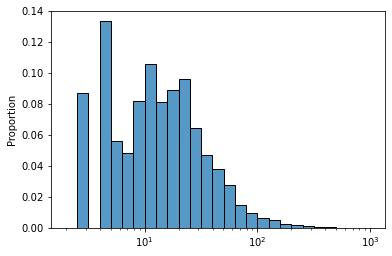

In [29]:
p = sns.histplot(x=list(filter(lambda x: x >= 3, map(len, nx.get_node_attributes(b, 'nodes').values()))),
                 stat='proportion', log_scale=True, bins=np.linspace(.3, 3, 28))

In [24]:
G = load_graph('lastfm_asia')
%lprun -f louvain -f objective_change -f objective_part -f _cluster_edges clustering(G)

Graph with 7624 nodes and 27806 edges
Graph with 1489 nodes and 8531 edges
Graph with 663 nodes and 5037 edges
Graph with 623 nodes and 4541 edges
